# EWC-EWA Mean Reversion

- Idea from Ernie Chan's "Algorithmic Trading" book
- Canada and Austrailia economies both driven by natural resource supply
- Equity markets for both countries show cointegration 
- Uses MSCI indicies to represent each countries equity market
- The spread between the markets is mean-reverting

In [34]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm
import statsmodels.tsa.vector_ar.vecm as vm
from pandas_datareader import data
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt

In [35]:
tickers = [
    'EWC', # iShares Canada
    'EWA', # iShares Australia
    ]

# 3 year sample period
start_date = (datetime.now() - timedelta(365 * 5)).strftime('%Y-%m-%d')
end_date = (datetime.now() - timedelta(365 * 2)).strftime('%Y-%m-%d')

start_date, end_date

('2015-02-17', '2018-02-16')

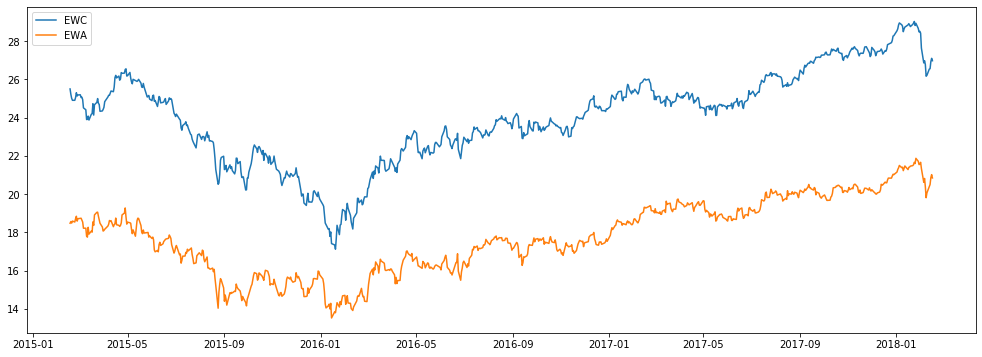

In [36]:
def get_yahoo_data(tickers, start_date, end_date):
    panel_data = data.DataReader(tickers , 'yahoo', start_date, end_date)
    df = panel_data.loc[:, ('Adj Close', slice(None))]
    df.columns = df.columns.droplevel()
    df.index = pd.to_datetime(df.index,  format = '%Y%m%d').date # remove HH:MM:SS
    
    return df

df = get_yahoo_data(tickers, start_date, end_date)
bmk = get_yahoo_data(['URTH'], start_date, end_date) # MSCI World used as a benchmark
plt.figure(figsize = (17, 6))
plt.plot(df.EWC, label = 'EWC')
plt.plot(df.EWA, label = 'EWA')
plt.legend()
plt.show()

## Trading logic

- [Johansen test](https://en.wikipedia.org/wiki/Johansen_test) for cointegration 
- Uses half-life formula to determine lookback period
- Uncapped position size...  
- Position size is volatility scaled

In [37]:
# eigenvalue decomposition to determine the weights
result = vm.coint_johansen(df.values, det_order = 0, k_ar_diff = 1)

print(f'Max eigenvalues: \n{result.lr2}\n') # both not stat significant...
print(f'Critical values for max eigenvalues: \n{result.cvm}\n')

print(f'Weights: {result.evec[:, 0]}')

Max eigenvalues: 
[12.05761173  1.17283995]

Critical values for max eigenvalues: 
[[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]

Weights: [ 1.37818329 -1.71822032]


In [38]:
def create_portfolio(df, jo_test_result):
    '''# uses the first column of eigenvectors as this will have the shortest
    # half life due to the eigenvectors are ordered with the strongest first
    # uses matrix multiplication to create a 1500x1 vector 'y_port'''
    y_port = pd.DataFrame(np.dot(df.values, jo_test_result.evec[:, 0]), #  ***look-ahead bias***
                      columns = ['y'], # single price the portfolio (eigenvector * prices)
                      index = df.index) #  (net) market value of portfolio

    y_port['y_lag'] = y_port.shift() # one day lag
    y_port['delta_y'] = y_port['y'] - y_port['y_lag']

    regress_results = sm.ols(formula = 'delta_y ~ y_lag', data = y_port).fit() # Note this can deal with NaN in top row

    halflife = -np.log(2) / regress_results.params['y_lag']
    # the steeper the slope of the regression line, the smaller (shorter) the half day
    
    #  Apply a simple linear mean reversion strategy to EWA-EWC
    lookback = np.round(halflife).astype(int) #  setting lookback to the halflife found above
    y_port['roll_avg'] = y_port['y'].rolling(lookback).mean()
    y_port['roll_std'] = y_port['y'].rolling(lookback).std()
                       
    # capital invested in portfolio in dollars.  
    # rolling z-score to determine position weights
    # no limits on num_units in this strategy
    # volatility scaled - lower vol results in a bigger positon size
    y_port['num_units'] = -(y_port['y'] - y_port['roll_avg']) / y_port['roll_std']
    
    # eigenvector can be viewed as the capital allocation (weights), 
    # while positions is the dollar capital in each ETF.
    num_units = np.expand_dims(y_port['num_units'].values, axis = 1)
    row_evecs = np.expand_dims(jo_test_result.evec[:, 0], axis=1).T
    
    # Dollar positions
    positions = pd.DataFrame(np.dot(num_units, row_evecs) * df.values, 
                             index = df.index,
                             columns = df.columns) 
    positions['capital'] = np.sum(np.abs(positions.shift()), axis = 1)
    
    return y_port, positions

y_port, positions = create_portfolio(df, result)

positions.tail()

Symbols,EWC,EWA,capital
2018-02-12,47.464978,-45.454995,89.486444
2018-02-13,52.337700,-50.375129,92.919974
2018-02-14,54.776626,-52.914221,102.712829
2018-02-15,52.180427,-50.457025,107.690847
2018-02-16,40.546140,-39.064298,102.637452


## Performance

- ok risk-adjusted return

In [39]:
def performance(y_port, positions, df):
    # daily P&L of the strategy
    y_port['pnl'] = np.sum((positions.iloc[:,:len(tickers)].shift().values) * (df.pct_change().values), axis = 1) 
    y_port['ret'] = y_port['pnl'] / positions['capital']
    y_port['cum_ret'] = np.cumprod(1 + y_port['ret']) - 1
    
    apr = round(np.prod(1 + y_port['ret']) ** (252 / len(y_port['ret'])) - 1, 4)
    sharpe = round(np.sqrt(252) * np.mean(y_port['ret']) / np.std(y_port['ret']), 4)
    
    return y_port, apr, sharpe

y_port, apr, sharpe = performance(y_port, positions, df)

print(f'APR: {apr} \nSharpe: {sharpe}\n')

APR: 0.0683 
Sharpe: 1.0126



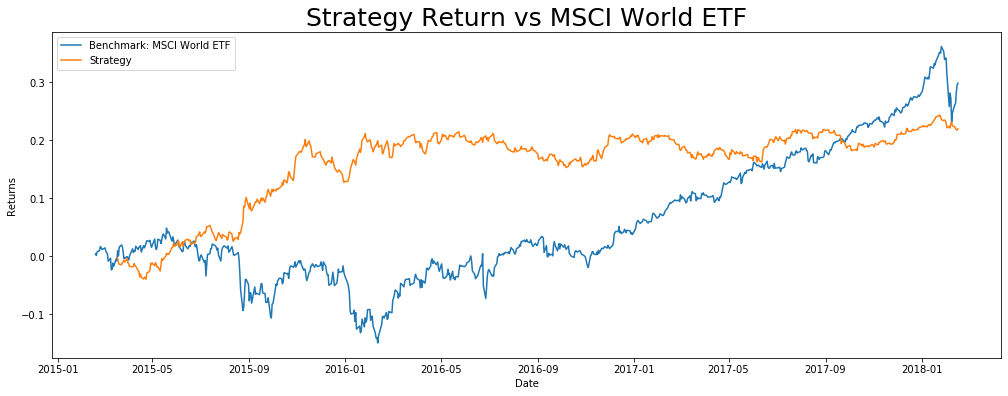

In [44]:
bmk_return = bmk.pct_change()
cum_bmk_return = np.cumprod(1 + bmk_return) - 1

plt.figure(figsize = (17, 6))
plt.title('Strategy Return vs MSCI World ETF', fontsize = 25)
plt.ylabel('Returns')
plt.xlabel('Date')
plt.plot(cum_bmk_return, label = 'Benchmark: MSCI World ETF')
plt.plot(y_port.cum_ret, label = 'Strategy')
plt.legend()
plt.show()